# Online Payments Fraud Detection

Card fraud (or in-store payment fraud) is expected to decline over the next decade. However, cardless transactions (such as  online or  phone payments) continue to grow as a percentage of total spending and  are much more susceptible to fraud.

Payment fraud involves the unauthorized use of false or stolen payment information with the intent to steal money, goods, or services. (https://www.checkout.com/blog/common-types-of-online-payment-fraud) 

### About Dataset
The below column reference:

1. **step**: maps a unit of time in the real world. In this case 1 step is 1 hour of time.
2. **type**: type of online transaction
3. **amount**: the amount of the transaction
4. **nameOrig**: customer starting the transaction
5. **oldbalanceOrg**: balance before the transaction
6. **newbalanceOrig**: balance after the transaction
7. **nameDest**: recipient of the transaction
8. **oldbalanceDest**: initial balance of recipient before the transaction
9. **newbalanceDest**: the new balance of recipient after the transaction
10. **isFraud**: fraud transaction

## Import Libraries and Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns
import warnings
import os
import zipfile
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.0f}'.format

In [4]:
import kagglehub
kagglehub.login()   

In [5]:
!kaggle d download -d "chitwanmanchanda/fraudulent-transactions-data"

Dataset URL: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data
License(s): CC0-1.0
fraudulent-transactions-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Unzip the downloaded dataset
with zipfile.ZipFile('fraudulent-transactions-data.zip', 'r') as zip_ref:
    zip_ref.extractall('fraudulent-transactions-data')

In [7]:
df = pd.read_csv("fraudulent-transactions-data/Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9840,C1231006815,170136,160296,M1979787155,0,0,0,0
1,1,PAYMENT,1864,C1666544295,21249,19385,M2044282225,0,0,0,0
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
3,1,CASH_OUT,181,C840083671,181,0,C38997010,21182,0,1,0
4,1,PAYMENT,11668,C2048537720,41554,29886,M1230701703,0,0,0,0


## Exploratory Data Analysis

### Explore general info and stats

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
mean,243,179862,833883,855114,1100702,1224996,0,0
std,142,603858,2888243,2924049,3399180,3674129,0,0
min,1,0,0,0,0,0,0,0
25%,156,13390,0,0,0,0,0,0
50%,239,74872,14208,0,132706,214661,0,0
75%,335,208721,107315,144258,943037,1111909,0,0
max,743,92445517,59585040,49585040,356015889,356179279,1,1


In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
df.duplicated().sum()

0

- Dataset has 11 columns and 6,362,620 rows
- Dataset has 8 numerical columns and 3 categorical columns
- Dataset has no missing values
- Dataset has no duplicated rows
- Except for the <code>isFraud</code> column, all numerical columns are positively skewed and mean is not a good measurement of central tendency to these data due to excessive standard deviation

### Analysis of Target Column (isFraud)

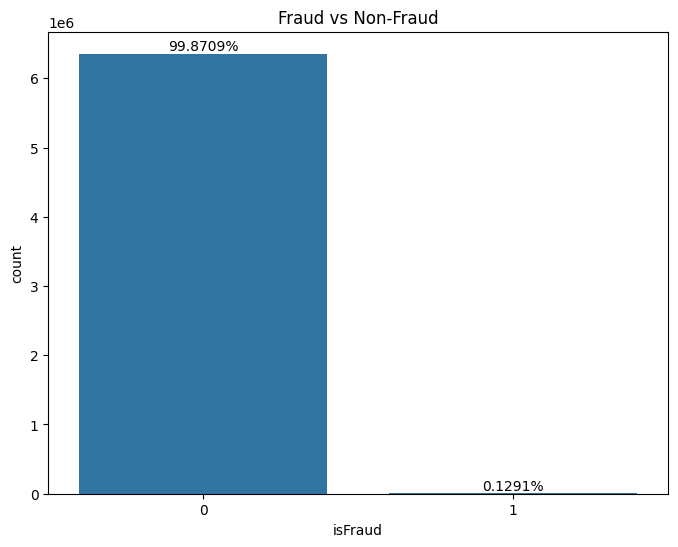

In [12]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud')
total = len(df)
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [13]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

The data imbalance is really visible in the plot above. This is a common thing around us, considering that if you compare the number of fraud cases with the total number of transactions, the comparison will be very small. In terms of building a Machine Learning model to detect fraud, this kind of data distribution is a problem. But don't worry, this problem can be overcome with various sampling techniques.

### Analysis of Transaction Type

In [14]:
df[['type','isFraud']].groupby('type').sum()

,isFraud
type,
CASH_IN,0
CASH_OUT,4116
DEBIT,0
PAYMENT,0
TRANSFER,4097


Most frauds occur in **cash out** and **transfer** transactions. This indicates that these types of transactions are more susceptible to fraudulent activities. While No fraud was detected in **cash in, debit**, and **payment** transactions in this dataset, suggesting that these transactions may inherently involve lower risk of fraudulent behavior.

Since there are only two types of transactions that are indicated as fraud, let's focus the analysis on these two types of transactions.

In [15]:
co_trans_df = df.loc[(df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')]

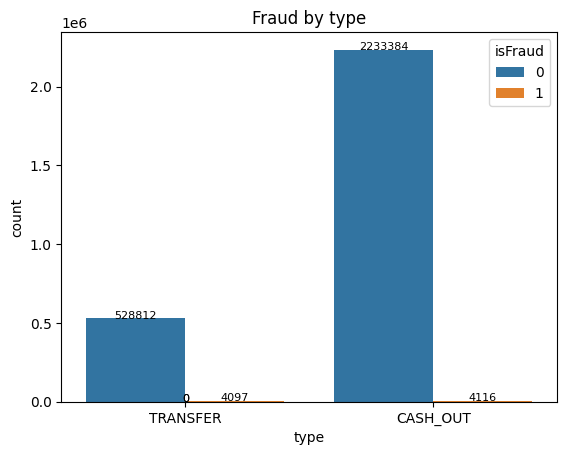

In [16]:
ax=sns.countplot(data=co_trans_df, x="type", hue="isFraud")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha = 'center', fontsize=8, color='black', xytext=(0, 0), textcoords='offset points')
plt.title("Fraud by type")
plt.show()

### Analysis of Balance

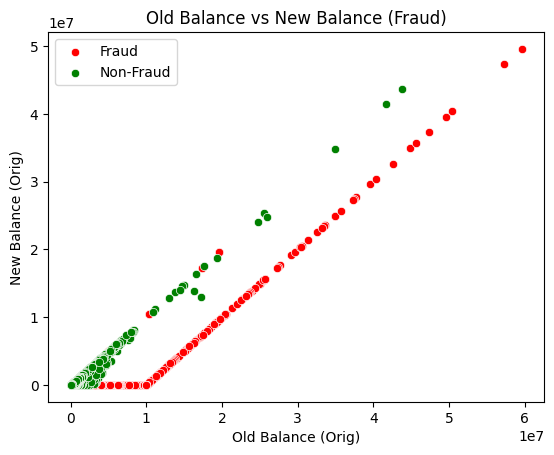

In [17]:
# Balance before and after transaction for fraud
fraud_df = co_trans_df.loc[co_trans_df['isFraud'] == 1]
non_fraud_df = co_trans_df.loc[co_trans_df['isFraud'] == 0]
sns.scatterplot(x='oldbalanceOrg', y='newbalanceOrig', data=fraud_df, color='red', label='Fraud')
sns.scatterplot(x='oldbalanceOrg', y='newbalanceOrig', data=non_fraud_df, color='green', label='Non-Fraud')
plt.title('Old Balance vs New Balance (Fraud)')
plt.xlabel('Old Balance (Orig)')
plt.ylabel('New Balance (Orig)')
plt.show()

The red (fraud) dots tend to be on a horizontal line where the New Balance is almost always close to zero, even though the Old Balance has a variety of values. This may indicate that fraudulent transactions often “drain” the balance to near zero, perhaps with the intention of cashing out completely. Additionally, there is another unique pattern in fraudulent transactions where the difference between the old balance and the new balance is always around 10 million.

### Feature Engineering

- **Remaining Balance** \
    Formula:
    $$remaining\_ balance = oldbalanceOrg - amount$$
    This feature represents the amount of balance remaining after a transaction.
    For fraudulent transactions, this feature may often be close to zero.
- **Balance Change Ratio** \
    Formula:
    $$balance\_change \_ ratio = (oldbalanceOrg - newbalanceOrig) / (oldbalanceOrg + 1\times10^{-9})$$
    This ratio measures the proportion of balance changes before and after a transaction.
    For fraud, these changes may show a different pattern than non-fraud.
- **Transaction Value Consistency** \
    Add logic to detect whether the transaction value makes sense:
    If $amount > oldbalanceOrg$, there is likely something strange, especially if the recipient's balance has not changed significantly.
- **Transaction Hours** \
    Convert <code>step</code> into transaction hours to display transaction hours in 24-hour format.


In [18]:
co_trans_df['remaining_balance'] = co_trans_df['oldbalanceOrg'] - co_trans_df['amount']
co_trans_df['balance_change_ratio'] = (co_trans_df['oldbalanceOrg'] - co_trans_df['newbalanceOrig']) / (co_trans_df['oldbalanceOrg'] + 1e-9)
co_trans_df['is_amount_reasonable'] = co_trans_df['amount'] <= co_trans_df['oldbalanceOrg']
co_trans_df['hours'] = co_trans_df['step'] % 24

### Analysis of Transaction Hours

In [19]:
# plot data
fraud_hours = co_trans_df['hours'].loc[co_trans_df['isFraud'] == 1].value_counts().sort_index()
non_fraud_hours = co_trans_df['hours'].loc[co_trans_df['isFraud'] == 0].value_counts().sort_index()

In [20]:
# Plot properties
values = [
    {
        "data": non_fraud_hours.values, 
        "color": "g", 
        "label": "Non-Fraud", 
        "yticks": [50000, 100000, 150000, 200000, 250000], 
        "yticklabels": ["50k", "100k", "150k", "200k", "250k"]
    },
    {
        "data": fraud_hours.values, 
        "color": "r", 
        "label": "Fraud", 
        "yticks": [200, 250, 300, 350], 
        "yticklabels": ["200", "250", "300", "350"]
    },
]
categories = fraud_hours.index


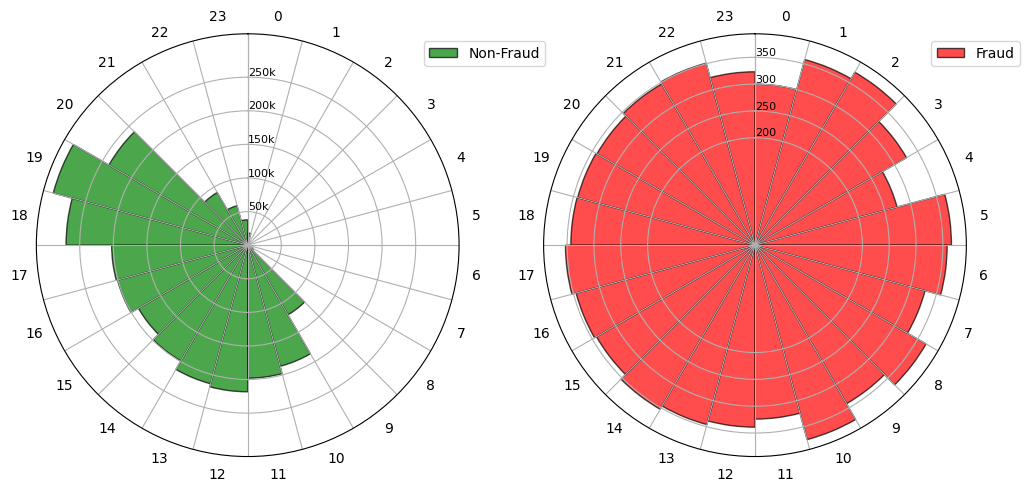

In [21]:
angles = np.linspace(0, 2 * np.pi, len(categories) + 1)
angles_mids = angles[:-1] + (angles[1] - angles[0]) / 2

# Plot
fig, axes = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(12, 6))

for ax, val in zip(axes, values):
    ax.bar(angles_mids, val["data"], width=angles[1] - angles[0],
           facecolor=val["color"], alpha=0.7, edgecolor='k', linewidth=1, label=val["label"])
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles_mids)
    ax.set_xticklabels(categories)
    ax.xaxis.set_minor_locator(FixedLocator(angles))
    ax.set_rlabel_position(0)
    ax.set_yticks(val["yticks"])
    ax.set_yticklabels(val["yticklabels"], color="black", size=8)
    ax.grid(True, axis='x', which='minor')
    ax.grid(False, axis='x', which='major')
    ax.grid(True, axis='y', which='major')
    ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1))

# plt.tight_layout()
plt.show()

The Non-Fraud plot shows a more even distribution across certain hours, with higher concentrations of transactions at certain times (e.g., between 6:00 PM and 8:00 PM). This may reflect users’ normal financial transaction habits (after work hours).

The Fraud plot shows that fraudulent transaction activity is more spread across time. This suggests that fraudsters may not be tied to a specific time of day. This distribution pattern indicates unusual activity compared to normal transactions, where there is a specific pattern in transaction hours (high frequency at certain hours).

## Model Interpretability

Setelah fitur baru ditambahkan, Anda dapat membangun model machine learning dan menganalisis kontribusi fitur dalam deteksi fraud:

### a. Pelatihan Model
Latih model sederhana (contoh: Random Forest):

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = co_trans_df[['hours','amount', 'oldbalanceOrg', 'newbalanceOrig', 'remaining_balance', 'balance_change_ratio']]
y = co_trans_df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### b. Analisis Kontribusi Fitur
Gunakan library seperti SHAP untuk memahami pentingnya fitur:

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualisasi SHAP
shap.summary_plot(shap_values[1], X_test)


Fitur dengan kontribusi terbesar menunjukkan pola yang kuat dalam mendeteksi fraud.